## Lead Scoring Case Study

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses
Leads: 
- through forms filled by people on website
- Referrals
X Education gets a lot of leads, its lead conversion rate is very poor
HotLeads: find potential candidate and followup them and convert them

X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. Ballpark of the target lead conversion rate to be around 80%.



The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
    - create dummies for all categorical variable
    - prepare test and train split
    - scaling
4. Modelling
    - use RFE
    - build logistic regression
    - check p-value and vif
    - find optimal probability cutoff
    - check performance of model on test data
    - generate score variable
5. Final analysis and recommendation

### 1. Read and understand Data

In [301]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')
# Importing Pandas and NumPy
import pandas as pd, numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [302]:
#reading the csv provided
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
leads_df = pd.read_csv("Leads.csv", sep=",", encoding="ISO-8859-1", header=0)
leads_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [303]:
#finding number of rows and columns
leads_df.shape

(9240, 37)

### Data Inspection

In [304]:

leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [305]:
leads_df.describe(include = 'all')

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
count,9240,9240.000000,9240,9204,9240,9240,9240.000000,9103.000000,9240.000000,9103.000000,9137,6779,7802,7033,6550,6531,9240,9240,9240,9240,9240,9240,9240,9240,5887,4473,9240,9240,6531,7820,5022,5022,5022.000000,5022.000000,9240,9240,9240
unique,9240,NaN,5,21,2,2,NaN,NaN,NaN,NaN,17,38,19,10,6,3,2,1,2,2,2,2,2,1,26,5,1,1,6,7,3,3,NaN,NaN,1,2,16
top,79d12483-d817-4fab-8ab0-7fff6c5581cb,NaN,Landing Page Submission,Google,No,No,NaN,NaN,NaN,NaN,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,02.Medium,NaN,NaN,No,No,Modified
freq,1,NaN,4886,2868,8506,9238,NaN,NaN,NaN,NaN,3437,6492,1942,5043,5600,6528,9226,9240,9238,9239,9239,9236,9233,9240,2072,1560,9240,9240,4146,3222,3839,2788,NaN,NaN,9240,6352,3407
mean,NaN,617188.435606,NaN,NaN,NaN,NaN,0.385390,3.445238,487.698268,2.362820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.306252,16.344883,NaN,NaN,NaN
std,NaN,23405.995698,NaN,NaN,NaN,NaN,0.486714,4.854853,548.021466,2.161418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.386694,1.811395,NaN,NaN,NaN
min,NaN,579533.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,11.000000,NaN,NaN,NaN
25%,NaN,596484.500000,NaN,NaN,NaN,NaN,0.000000,1.000000,12.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,15.000000,NaN,NaN,NaN
50%,NaN,615479.000000,NaN,NaN,NaN,NaN,0.000000,3.000000,248.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,16.000000,NaN,NaN,NaN
75%,NaN,637387.250000,NaN,NaN,NaN,NaN,1.000000,5.000000,936.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,18.000000,NaN,NaN,NaN


### 2. Cleaning of Data

In [306]:
#changing all select to null as Select means non-mandatory field which was not selected by user and select got populated in db

leads_df = leads_df.replace('Select', np.nan)
leads_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,NaN,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,NaN,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NaN,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [307]:
leads_df.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [308]:
# missing values
round(100*(leads_df.isnull().sum())/len(leads_df), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [309]:
#removing column which has more than 75% of data that is not available
#leads_df = leads_df.drop('How did you hear about X Education')
leads_df = leads_df.drop(leads_df.loc[:,list(round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)>75)].columns, 1)
leads_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,NaN,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [310]:
round(100*(leads_df.isnull().sum())/len(leads_df), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

In [311]:
leads_df.columns


Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

- 'Prospect ID' and 'Lead Number' are unique so one column from these two can be dropped

#### Analysing each columns null values

In [312]:
leads_df['Lead Source'].describe()

count       9204
unique        21
top       Google
freq        2868
Name: Lead Source, dtype: object

In [313]:
leads_df['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
youtubechannel          1
welearnblog_Home        1
blog                    1
testone                 1
NC_EDM                  1
WeLearn                 1
Pay per Click Ads       1
Name: Lead Source, dtype: int64

In [314]:
# very few % have null values so we can replace those with the mode i.e Google which will not cause any issues
leads_df['Lead Source'] = leads_df['Lead Source'].replace(np.nan, 'Google')
leads_df['Lead Source'] = leads_df['Lead Source'].replace('google', 'Google')

In [315]:
leads_df['TotalVisits'].describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [316]:
# very around 1% that have null values so we can replace those with the mean
leads_df['TotalVisits'] = leads_df['TotalVisits'].replace(np.nan, leads_df['TotalVisits'].mean())

In [317]:
leads_df['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [318]:
# very around 1% that have null values so we can replace those with the mean
leads_df['Page Views Per Visit'] = leads_df['Page Views Per Visit'].replace(np.nan, leads_df['Page Views Per Visit'].mean())

In [319]:
leads_df['Last Activity'].value_counts()

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

In [320]:
# 1% have null values so we can replace those with the mode i.e Email Opened which will not cause any issues
leads_df['Last Activity'] = leads_df['Last Activity'].replace(np.nan, 'Email Opened')

In [321]:
leads_df['Country'].value_counts()

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Germany                    4
South Africa               4
Canada                     4
Nigeria                    4
Kuwait                     4
Sweden                     3
Belgium                    2
China                      2
Ghana                      2
Uganda                     2
Bangladesh                 2
Italy                      2
Philippines                2
Asia/Pacific Region        2
Netherlands                2
Vietnam                    1
Malaysia                   1
Liberia                    1
Indonesia                  1
Switzerland                1
Kenya                      1
Tanzania      

In [322]:
# data suggest india is the most frequent data, others being very negligible so we can easy replace null with India, and this columns is worth dropping
leads_df['Country'] = leads_df['Country'].replace(np.nan, 'India')
leads_df['Country'] = leads_df['Country'].replace('unknown', 'India')


In [323]:
leads_df['Specialization'].value_counts()

Finance Management                   976
Human Resource Management            848
Marketing Management                 838
Operations Management                503
Business Administration              403
IT Projects Management               366
Supply Chain Management              349
Banking, Investment And Insurance    338
Media and Advertising                203
Travel and Tourism                   203
International Business               178
Healthcare Management                159
Hospitality Management               114
E-COMMERCE                           112
Retail Management                    100
Rural and Agribusiness                73
E-Business                            57
Services Excellence                   40
Name: Specialization, dtype: int64

In [324]:
# around 37% data not available and no clear pattern to suggest anything about this data so we can keep it for dropping in future at present we can change null to NA
leads_df['Specialization'] = leads_df['Specialization'].replace(np.nan, 'NA')

In [325]:
leads_df['What is your current occupation'].value_counts()

Unemployed              5600
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [326]:
100*(leads_df['What is your current occupation'].value_counts()/len(leads_df))

Unemployed              60.606061
Working Professional     7.640693
Student                  2.272727
Other                    0.173160
Housewife                0.108225
Businessman              0.086580
Name: What is your current occupation, dtype: float64

In [327]:
#60% of the data is unemployed so lets assume null values are unemployed too.
leads_df['What is your current occupation'] = leads_df['What is your current occupation'].replace(np.nan, 'Unemployed')

In [328]:
leads_df['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [329]:
#Most of the data is Better Career Prospects so lets assume null values are Better Career Prospects too. This column is worth dropping too
leads_df['What matters most to you in choosing a course'] = leads_df['What matters most to you in choosing a course'].replace(np.nan, 'Better Career Prospects')

In [330]:
leads_df['Tags'].value_counts()

Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with EINS                                     12
Lost to Others

In [331]:
100*(leads_df['Tags'].value_counts()/len(leads_df))

Will revert after reading the email                  22.424242
Ringing                                              13.019481
Interested in other courses                           5.551948
Already a student                                     5.032468
Closed by Horizzon                                    3.874459
switched off                                          2.597403
Busy                                                  2.012987
Lost to EINS                                          1.893939
Not doing further education                           1.569264
Interested  in full time MBA                          1.266234
Graduation in progress                                1.201299
invalid number                                        0.898268
Diploma holder (Not Eligible)                         0.681818
wrong number given                                    0.508658
opp hangup                                            0.357143
number not provided                                   0

In [332]:
# around 37% data not available and no clear pattern to suggest anything about this data so we can keep it for dropping in future at present we can change null to NA
leads_df['Tags'] = leads_df['Tags'].replace(np.nan, 'NA')

In [333]:
leads_df['Lead Quality'].value_counts()

Might be             1560
Not Sure             1092
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

In [334]:
# around 52% data not available and no clear pattern to suggest anything about this data so we can keep it for dropping in future at present we can change null to NA
leads_df['Lead Quality'] = leads_df['Lead Quality'].replace(np.nan, 'NA')

In [335]:
leads_df['Lead Profile'].value_counts()

Potential Lead                 1613
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

In [336]:
# around 72% data not available and no clear pattern to suggest anything about this data so we can keep it for dropping in future at present we can change null to NA
leads_df['Lead Profile'] = leads_df['Lead Profile'].replace(np.nan, 'NA')

In [337]:
leads_df['City'].value_counts()

Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [338]:
100*(leads_df['City'].value_counts()/leads_df['City'].count())

Mumbai                         57.835218
Thane & Outskirts              13.498474
Other Cities                   12.313768
Other Cities of Maharashtra     8.203195
Other Metro Cities              6.821038
Tier II Cities                  1.328307
Name: City, dtype: float64

In [339]:
#60% of the data is Mumbai so lets assume null values are Mumbai too.
leads_df['City'] = leads_df['City'].replace(np.nan, 'Mumbai')

In [340]:
leads_df['Asymmetrique Activity Index'].value_counts()

02.Medium    3839
01.High       821
03.Low        362
Name: Asymmetrique Activity Index, dtype: int64

In [341]:
100*(leads_df['Asymmetrique Activity Index'].value_counts()/leads_df['Asymmetrique Activity Index'].count())

02.Medium    76.443648
01.High      16.348068
03.Low        7.208284
Name: Asymmetrique Activity Index, dtype: float64

In [342]:
100*(leads_df['Asymmetrique Profile Index'].value_counts()/leads_df['Asymmetrique Profile Index'].count())

02.Medium    55.515731
01.High      43.866985
03.Low        0.617284
Name: Asymmetrique Profile Index, dtype: float64

In [343]:
100*(leads_df['Asymmetrique Activity Score'].value_counts()/leads_df['Asymmetrique Activity Score'].count())

14.0    35.264835
15.0    25.746714
13.0    15.432099
16.0     9.299084
17.0     6.949423
12.0     3.902828
11.0     1.891677
10.0     1.135006
9.0      0.179211
18.0     0.099562
8.0      0.079650
7.0      0.019912
Name: Asymmetrique Activity Score, dtype: float64

In [344]:
100*(leads_df['Asymmetrique Profile Score'].value_counts()/leads_df['Asymmetrique Profile Score'].count())

15.0    35.025886
18.0    21.326165
16.0    11.927519
17.0    11.529271
20.0     6.133015
19.0     4.878534
14.0     4.500199
13.0     4.062127
12.0     0.438072
11.0     0.179211
Name: Asymmetrique Profile Score, dtype: float64

In [345]:
# with the data above it is difficult to fill values for null, so Asymmetrique Activity Index, Asymmetrique Activity Score, Asymmetrique Profile Index and Asymmetrique Profile Score 
# become good candidate for dropping

leads_df = leads_df.drop(['Asymmetrique Activity Index','Asymmetrique Activity Score','Asymmetrique Profile Index','Asymmetrique Profile Score'],1)

#### Final data after cleaning

In [346]:
round(100*(leads_df.isnull().sum())/len(leads_df), 2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                            

In [347]:
leads_df.shape

(9240, 32)

In [348]:
leads_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,India,NA,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,NA,Mumbai,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NA,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NA,No,No,NA,Mumbai,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,NA,Mumbai,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NA,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,NA,Mumbai,No,No,Modified


In [349]:
leads_df.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

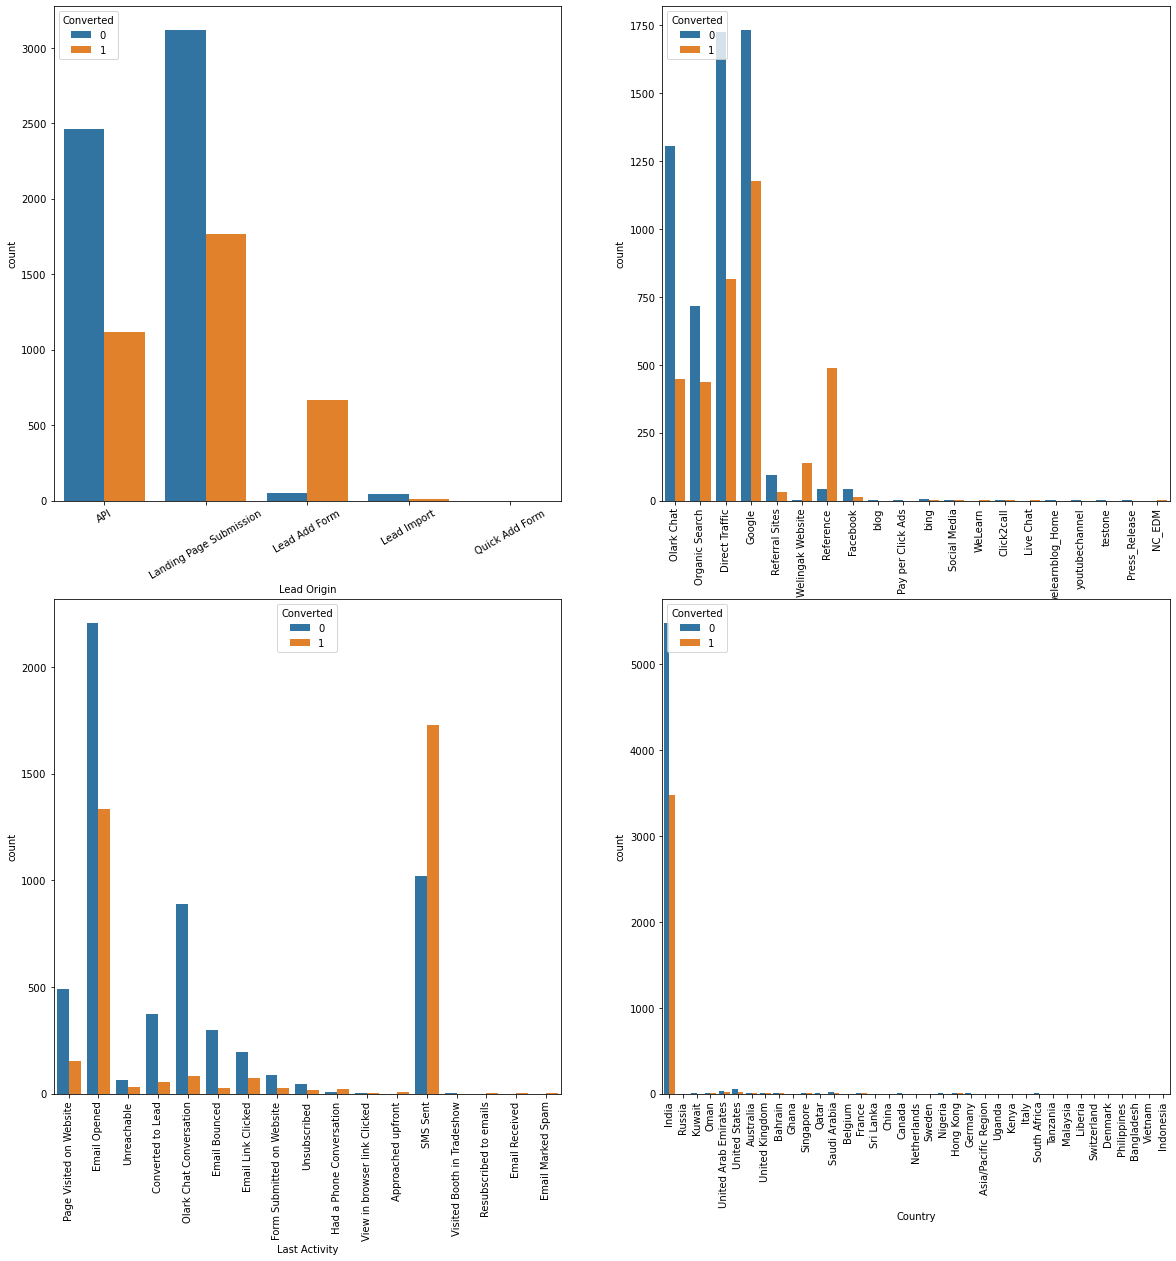

In [350]:

fig, axes = plt.subplots(2,2 , figsize=(20, 20))

a = sns.countplot(ax=axes[0,0],x = "Lead Origin", hue = "Converted", data = leads_df)
a.set_xticklabels(a.get_xticklabels(),rotation=30)

b=sns.countplot(ax=axes[0,1], x = "Lead Source", hue = "Converted", data = leads_df)
b.set_xticklabels(b.get_xticklabels(),rotation=90)

c=sns.countplot(ax=axes[1,0], x = "Last Activity", hue = "Converted", data = leads_df)
c.set_xticklabels(c.get_xticklabels(),rotation=90)

d=sns.countplot(ax=axes[1,1], x = "Country", hue = "Converted", data = leads_df)
d.set_xticklabels(d.get_xticklabels(),rotation=90)

plt.show()

- Lead Orgin
    - API and Landing Page submission has high number but conversion was less
    - Lead Add Form has less number and high converion
    - Conclusion: Increase conversion of API and Landing Page Submission. Increase Lead Add Form counts
- Lead Source
    - Wellingak Website and Reference has high conversion rate but less counts
    - olrak chat, organic search, direct traffic, google has huge count
    - Conclusion: Increase wellingak Website and reference count and increase convertion of olrak chat, organic search,           direct traffic, google
- Last Activity
    - SMS Sent conversion is high
    - Eamil opened conversion is less than count but high in number
    - Conclusion: Focus on increasing SMS sent and email opened
- Country
    - India has most traffic which is significantly high
    - Conclusion: Focus should be India, other countries can be ignored. In short, we can drop is columns too

In [351]:
#combining data which are not significant into one for lead source
laothers = ['Unreachable ','Unsubscribed','Had a Phone Conversation','Approached upfront','View in browser link Clicked','Email Marked Spam','Email Received','Visited Booth in Tradeshow','Resubscribed to emails','Unreachable']
leads_df['Last Activity'] = leads_df['Last Activity'].replace(laothers, 'Others')
leads_df['Last Activity'].value_counts()

Email Opened                 3540
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Email Link Clicked            267
Others                        205
Form Submitted on Website     116
Name: Last Activity, dtype: int64

In [352]:
def others(x):
    category = ""
    if x == "India":
        category = "India"
    else:
        category = "Outside india"
    return category

leads_df['Country'] = leads_df.apply(lambda x:others(x['Country']), axis = 1)
leads_df['Country'].value_counts()

India            8958
Outside india     282
Name: Country, dtype: int64

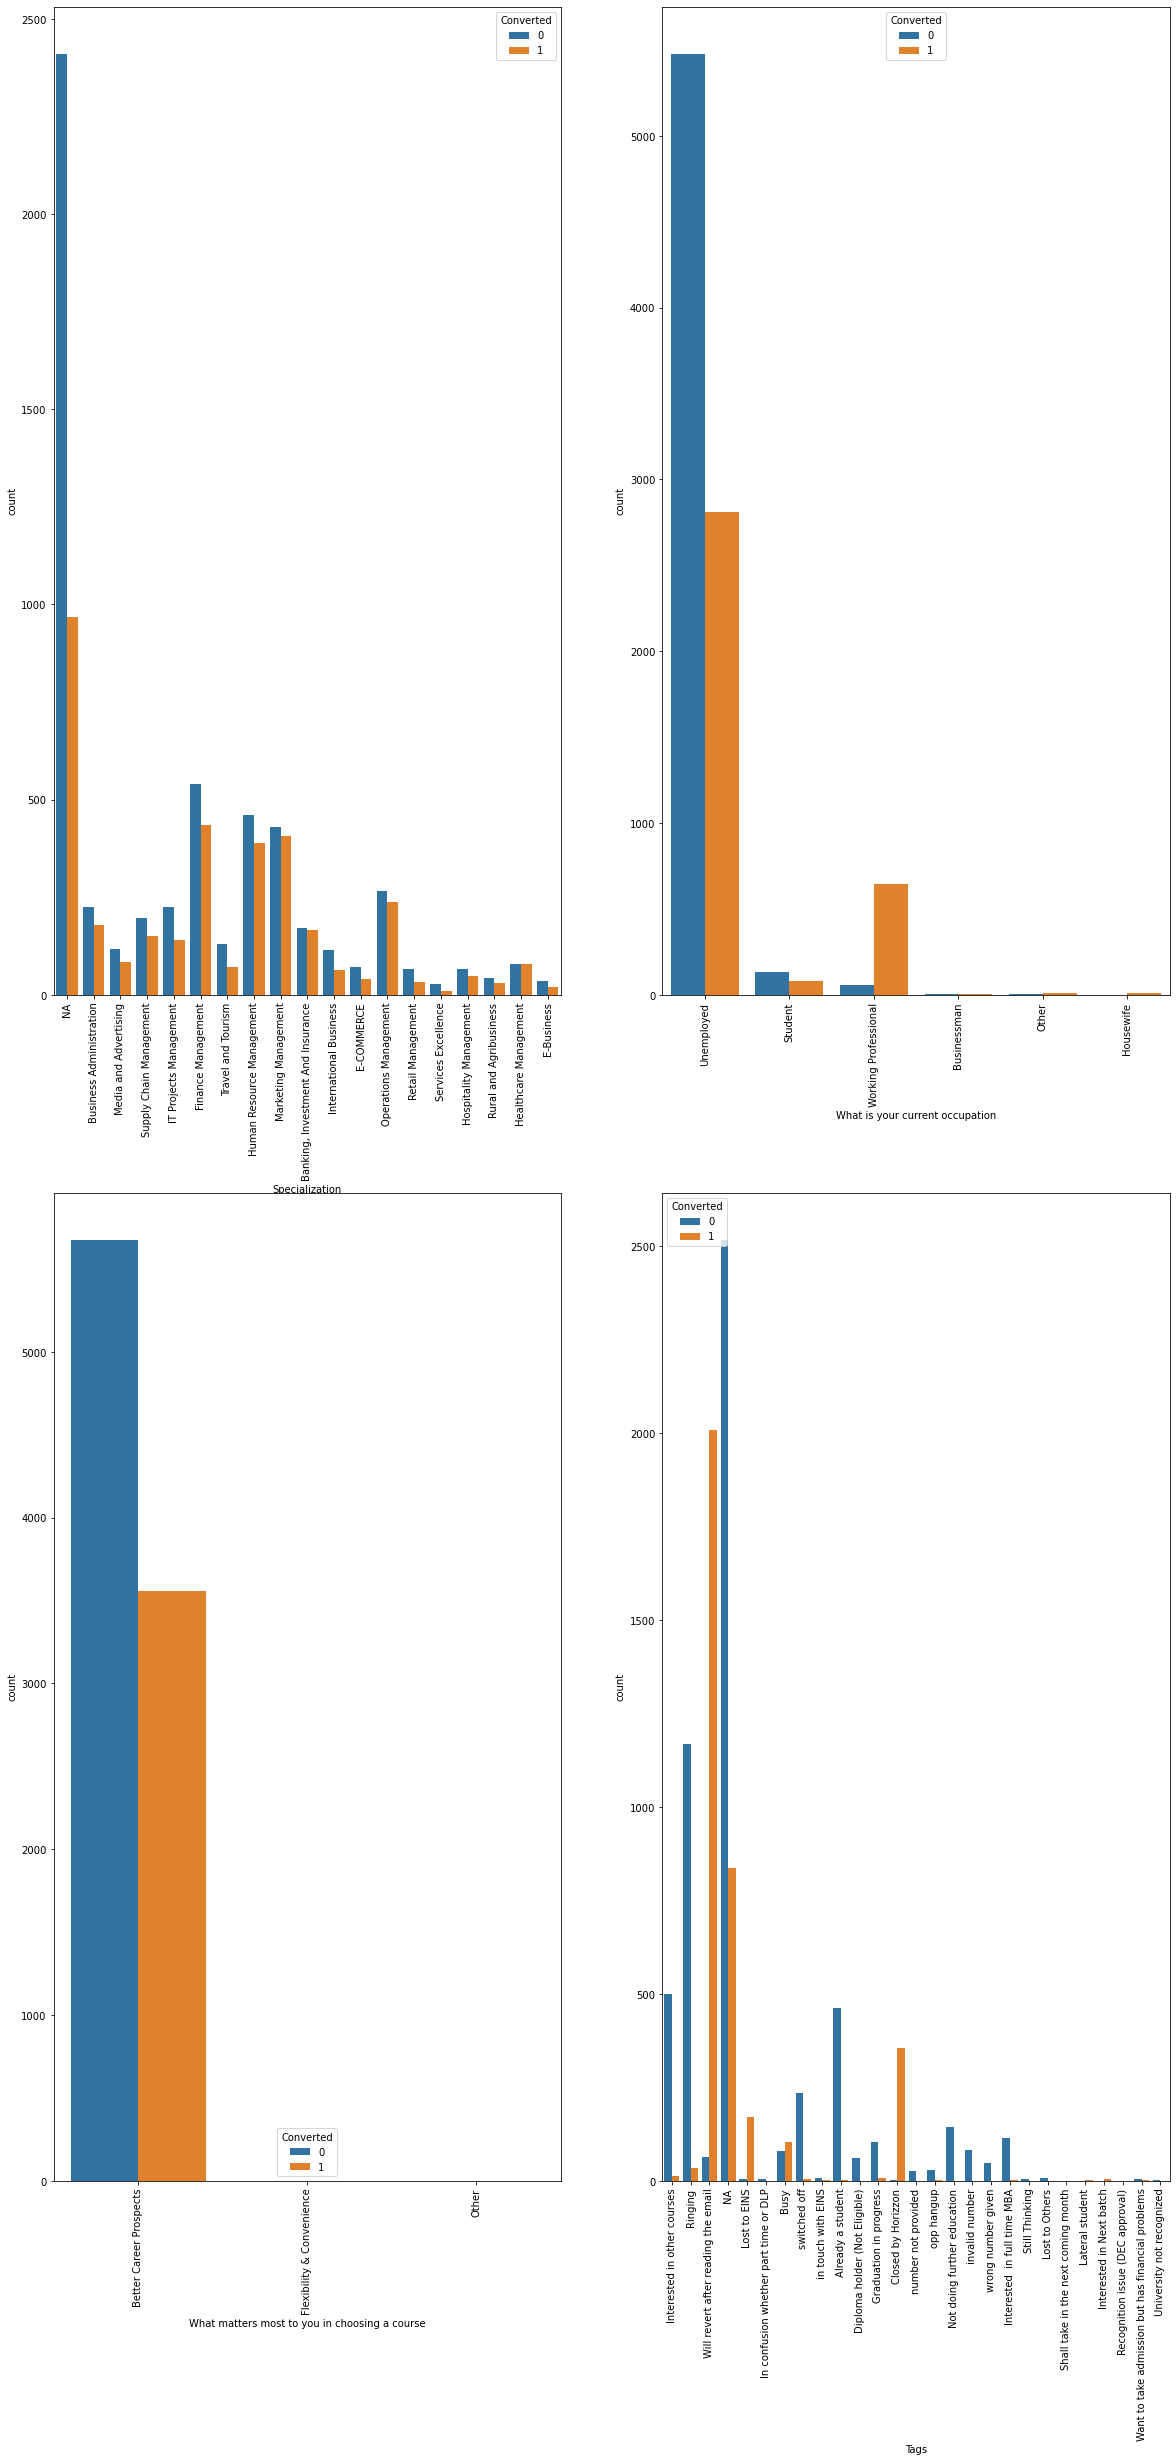

In [353]:
fig, axes = plt.subplots(2,2 , figsize=(20, 40))

e=sns.countplot(ax=axes[0,0], x = "Specialization", hue = "Converted", data = leads_df)
e.set_xticklabels(e.get_xticklabels(),rotation=90)

f=sns.countplot(ax=axes[0,1], x = "What is your current occupation", hue = "Converted", data = leads_df)
f.set_xticklabels(f.get_xticklabels(),rotation=90)

g=sns.countplot(ax=axes[1,0], x = "What matters most to you in choosing a course", hue = "Converted", data = leads_df)
g.set_xticklabels(g.get_xticklabels(),rotation=90)


h = sns.countplot(ax=axes[1,1], x = "Tags", hue = "Converted", data = leads_df)
h.set_xticklabels(h.get_xticklabels(),rotation=90)

plt.show()


- Specialization
    - NA has huge count and good enough conversion
    - Financial management, Human Resource Management, Marketing Management and Operation management has good count and conversion rate
    - conclusion: Find the specialization of NA and increase the numbers for other
- What is current occupation
    - Unemployed count and conversion are very high
    - working professional have high conversion rate
    - Conclusion: Focus on increasing unemployed conversion rate. Focus on working profression and increase the count
- What matters most to you in choosing a course
    - Conclusion: Better career Prospects is the only option. So we can ignore this column
- Tags
    - will revert after reading the email high conversion rate
    - NA has high count
    - conclusion: Focus on finding NA and getting them converted

In [354]:
def others(x):
    category = ""
    if x == "Unemployed":
        category = "Unemployed"
    elif x == "Working Professional":
        category = "Working Professional"
    else:
        category = "Others"
    return category

leads_df['What is your current occupation'] = leads_df.apply(lambda x:others(x['What is your current occupation']), axis = 1)
leads_df['What is your current occupation'].value_counts()

Unemployed              8290
Working Professional     706
Others                   244
Name: What is your current occupation, dtype: int64

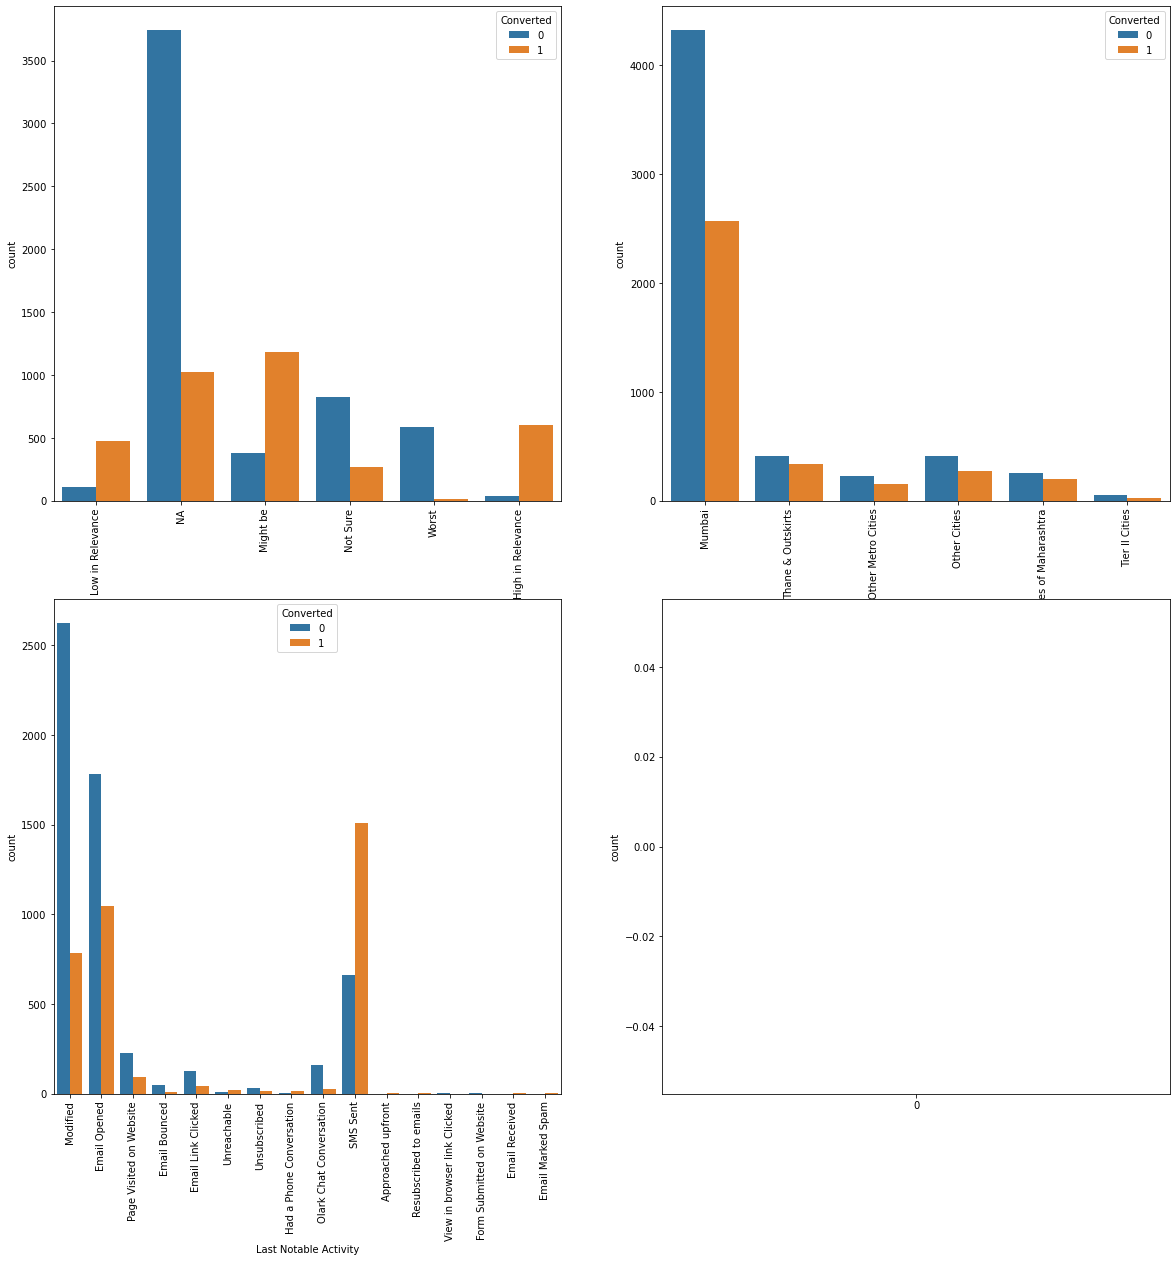

In [355]:
fig, axes = plt.subplots(2,2 , figsize=(20, 20))

i=sns.countplot(ax=axes[0,0], x = "Lead Quality", hue = "Converted", data = leads_df)
i.set_xticklabels(i.get_xticklabels(),rotation=90)

j=sns.countplot(ax=axes[0,1], x = "City", hue = "Converted", data = leads_df)
j.set_xticklabels(j.get_xticklabels(),rotation=90)

k=sns.countplot(ax=axes[1,0], x = "Last Notable Activity", hue = "Converted", data = leads_df)
k.set_xticklabels(k.get_xticklabels(),rotation=90)

sns.countplot(ax=axes[1,1])

plt.show()

- Lead Quality
    - NA has high count
    - Might be and High Revelance has high conversion rate
    - Conclusion: Focus on increasing might be and high revelance count and increase NA conversion count
- City
    - Mumbai has high count and conversion rate
    - Conclusion: Fcous on the places other than mumbai
- last Notable Activity
    - Conclusion: has almost same data as Last activity so can be dropped

In [356]:
def others(x):
    category = ""
    if x == "Mumbai":
        category = "Mumbai"
    else:
        category = "Rest of India"
    return category

leads_df['City'] = leads_df.apply(lambda x:others(x['City']), axis = 1)
leads_df['City'].value_counts()

Mumbai           6891
Rest of India    2349
Name: City, dtype: int64

In [357]:
leads_df.columns


Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [358]:
leads_df['Do Not Email'].value_counts()

No     8506
Yes     734
Name: Do Not Email, dtype: int64

In [359]:
leads_df['Do Not Call'].value_counts()

No     9238
Yes       2
Name: Do Not Call, dtype: int64

In [360]:
leads_df['TotalVisits'].describe()

count    9240.000000
mean        3.445238
std         4.818723
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [361]:
leads_df['Page Views Per Visit'].describe()

count    9240.000000
mean        2.362820
std         2.145333
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [362]:
leads_df['Total Time Spent on Website'].describe()

count    9240.000000
mean      487.698268
std       548.021466
min         0.000000
25%        12.000000
50%       248.000000
75%       936.000000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

In [363]:
leads_df['Search'].value_counts()

No     9226
Yes      14
Name: Search, dtype: int64

In [364]:
leads_df['Magazine'].value_counts()

No    9240
Name: Magazine, dtype: int64

In [365]:
leads_df['Newspaper Article'].value_counts()

No     9238
Yes       2
Name: Newspaper Article, dtype: int64

In [366]:
leads_df['X Education Forums'].value_counts()

No     9239
Yes       1
Name: X Education Forums, dtype: int64

In [367]:
leads_df['Newspaper'].value_counts()

No     9239
Yes       1
Name: Newspaper, dtype: int64

In [368]:
leads_df['Digital Advertisement'].value_counts()

No     9236
Yes       4
Name: Digital Advertisement, dtype: int64

In [369]:
leads_df['Through Recommendations'].value_counts()

No     9233
Yes       7
Name: Through Recommendations, dtype: int64

In [370]:
leads_df['Receive More Updates About Our Courses'].value_counts()

No    9240
Name: Receive More Updates About Our Courses, dtype: int64

In [371]:
leads_df['Update me on Supply Chain Content'].value_counts()

No    9240
Name: Update me on Supply Chain Content, dtype: int64

In [372]:
leads_df['Get updates on DM Content'].value_counts()

No    9240
Name: Get updates on DM Content, dtype: int64

In [373]:
leads_df['I agree to pay the amount through cheque'].value_counts()

No    9240
Name: I agree to pay the amount through cheque, dtype: int64

In [374]:
leads_df['A free copy of Mastering The Interview'].value_counts()

No     6352
Yes    2888
Name: A free copy of Mastering The Interview, dtype: int64

- 'Search','Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview','What matters most to you in choosing a course'
can be dropped as all columns are inbalanced


In [375]:
#dropping unwanted columns
leads_df=leads_df.drop(['Prospect ID','Search','Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 
                        'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 
                        'Update me on Supply Chain Content', 'Get updates on DM Content', 
                        'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview','Last Notable Activity', 'Country','What matters most to you in choosing a course'],1)

In [376]:
leads_df.shape

(9240, 16)

### 3. Prepare the data for modelling

#### Converting some binary variables (Yes/No) to 0/1

In [377]:
leads_df.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags',
       'Lead Quality', 'Lead Profile', 'City'],
      dtype='object')

In [378]:
# List of variables to map

varlist =  ['Do Not Call','Do Not Email']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the leads list
leads_df[varlist] = leads_df[varlist].apply(binary_map)

In [379]:
leads_df.shape

(9240, 16)

In [380]:
leads_df.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,Lead Quality,Lead Profile,City
0,660737,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,NA,Unemployed,Interested in other courses,Low in Relevance,NA,Mumbai
1,660728,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,NA,Unemployed,Ringing,NA,NA,Mumbai
2,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,Business Administration,Others,Will revert after reading the email,Might be,Potential Lead,Mumbai
3,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Not Sure,NA,Mumbai
4,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,NA,Unemployed,Will revert after reading the email,Might be,NA,Mumbai


In [381]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Lead Number                      9240 non-null   int64  
 1   Lead Origin                      9240 non-null   object 
 2   Lead Source                      9240 non-null   object 
 3   Do Not Email                     9240 non-null   int64  
 4   Do Not Call                      9240 non-null   int64  
 5   Converted                        9240 non-null   int64  
 6   TotalVisits                      9240 non-null   float64
 7   Total Time Spent on Website      9240 non-null   int64  
 8   Page Views Per Visit             9240 non-null   float64
 9   Last Activity                    9240 non-null   object 
 10  Specialization                   9240 non-null   object 
 11  What is your current occupation  9240 non-null   object 
 12  Tags                

In [382]:
#trying to find correlation
leads_df.corr()

,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
Lead Number,1.000000,-0.098529,0.011913,0.025157,0.021993,0.020329,0.058198
Do Not Email,-0.098529,1.000000,-0.004322,-0.135580,0.033609,-0.046374,0.033351
Do Not Call,0.011913,-0.004322,1.000000,0.018581,0.003221,0.006801,-0.005918
Converted,0.025157,-0.135580,0.018581,1.000000,0.030091,0.362483,-0.003294
TotalVisits,0.021993,0.033609,0.003221,0.030091,1.000000,0.218409,0.512125
Total Time Spent on Website,0.020329,-0.046374,0.006801,0.362483,0.218409,1.000000,0.316262
Page Views Per Visit,0.058198,0.033351,-0.005918,-0.003294,0.512125,0.316262,1.000000


#### For categorical variables with multiple levels, create dummy features (one-hot encoded)

In [383]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(leads_df[['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation',
                              'Tags','Lead Quality','Lead Profile']], drop_first=True)

# Adding the results to the master dataframe
leads_df = pd.concat([leads_df, dummy1], axis=1)

In [384]:
leads_df.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,Lead Quality,Lead Profile,City,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_NA,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_NA,Lead Quality_Not Sure,Lead Quality_Worst,Lead Profile_Lateral Student,Lead Profile_NA,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool
0,660737,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,NA,Unemployed,Interested in other courses,Low in Relevance,NA,Mumbai,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,660728,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,NA,Unemployed,Ringing,NA,NA,Mumbai,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,Business Administration,Others,Will revert after reading the email,Might be,Potential Lead,Mumbai,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Not Sure,NA,Mumbai,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Conve

In [385]:
leads_df.shape

(9240, 103)

In [386]:
leads_df=leads_df.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation',
                              'Tags','Lead Quality','City','Lead Profile'],1)
leads_df.head()

,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_NA,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_NA,Lead Quality_Not Sure,Lead Quality_Worst,Lead Profile_Lateral Student,Lead Profile_NA,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool
0,660737,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,660728,0,0,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,660727,0,0,1,2.0,1532,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,660719,0,0,0,1.0,305,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,660681,0,0,1,2.0,1428,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [387]:
leads_df.shape

(9240, 94)

In [388]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 94 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Lead Number                                             9240 non-null   int64  
 1   Do Not Email                                            9240 non-null   int64  
 2   Do Not Call                                             9240 non-null   int64  
 3   Converted                                               9240 non-null   int64  
 4   TotalVisits                                             9240 non-null   float64
 5   Total Time Spent on Website                             9240 non-null   int64  
 6   Page Views Per Visit                                    9240 non-null   float64
 7   Lead Origin_Landing Page Submission                     9240 non-null   uint8  
 8   Lead Origin_Lead Add Form             

#### Checking for Outliers

In [389]:
# Checking for outliers in the continuous variables
num_leads_df= leads_df[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]

In [390]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
num_leads_df.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9240.000000,9240.000000
mean,3.445238,487.698268,2.362820
std,4.818723,548.021466,2.145333
min,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1.000000
50%,3.000000,248.000000,2.000000
75%,5.000000,936.000000,3.000000
90%,7.000000,1380.000000,5.000000
95%,10.000000,1562.000000,6.000000
99%,17.000000,1840.610000,9.000000


- From the distribution shown above, we can see that there are outliers in data.

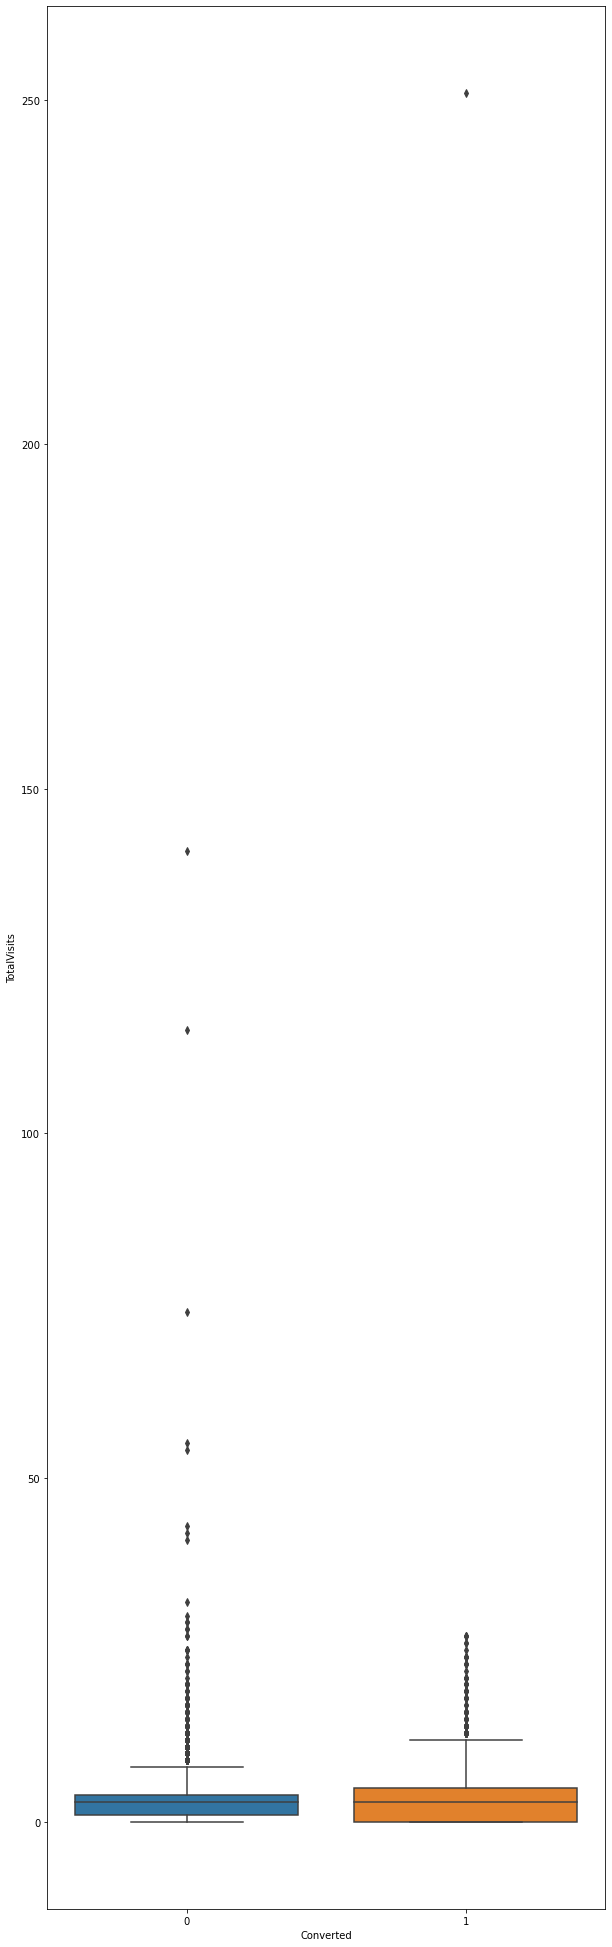

In [391]:
plt.figure(figsize=(10,35))
sns.boxplot(x=leads_df.Converted, y=leads_df['TotalVisits'])
plt.show()

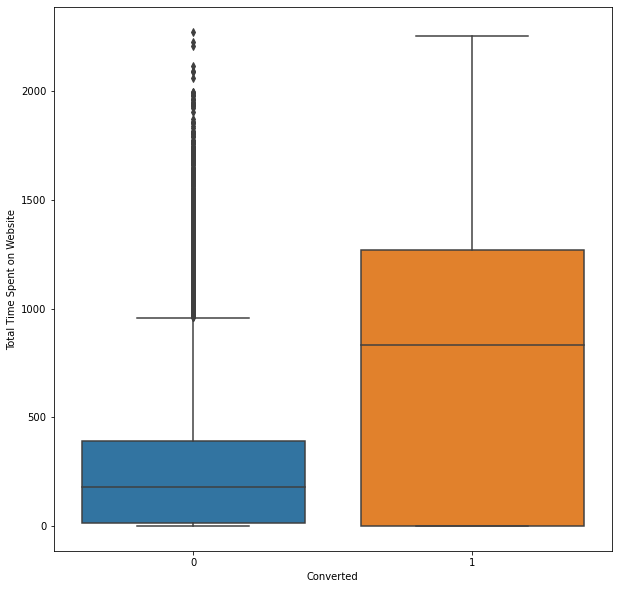

In [392]:
plt.figure(figsize=(10,10))
sns.boxplot(x=leads_df.Converted, y=leads_df['Total Time Spent on Website'])
plt.show()

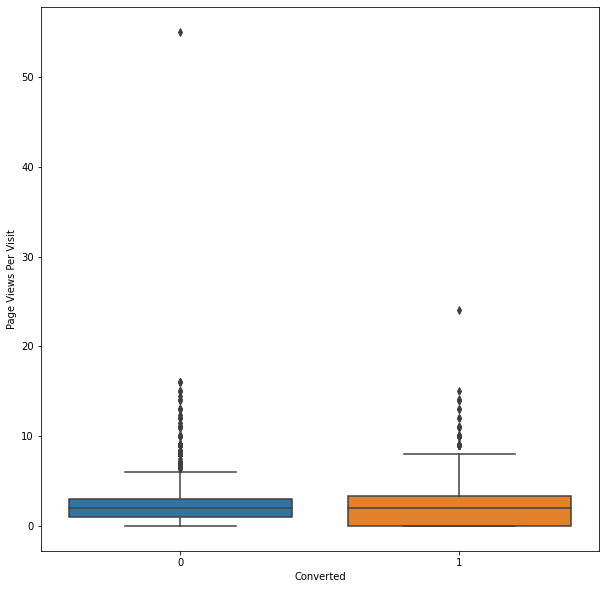

In [393]:
plt.figure(figsize=(10,10))
sns.boxplot(x=leads_df.Converted, y=leads_df['Page Views Per Visit'])
plt.show()

In [394]:
# capping outliers for total visit
Q1 = leads_df.TotalVisits.quantile(0.05)
Q3 = leads_df.TotalVisits.quantile(0.95)
IQR = Q3 - Q1
leads_df = leads_df[(leads_df.TotalVisits >= Q1 - 1.5*IQR) & (leads_df.TotalVisits <= Q3 + 1.5*IQR)]

# outlier treatment for Total Time Spent on Website
Q1 = leads_df['Total Time Spent on Website'].quantile(0.05)
Q3 = leads_df['Total Time Spent on Website'].quantile(0.95)
IQR = Q3 - Q1
leads_df = leads_df[(leads_df['Total Time Spent on Website'] >= Q1 - 1.5*IQR) & (leads_df['Total Time Spent on Website'] <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = leads_df['Page Views Per Visit'].quantile(0.05)
Q3 = leads_df['Page Views Per Visit'].quantile(0.95)
IQR = Q3 - Q1
leads_df = leads_df[(leads_df['Page Views Per Visit'] >= Q1 - 1.5*IQR) & (leads_df['Page Views Per Visit'] <= Q3 + 1.5*IQR)]

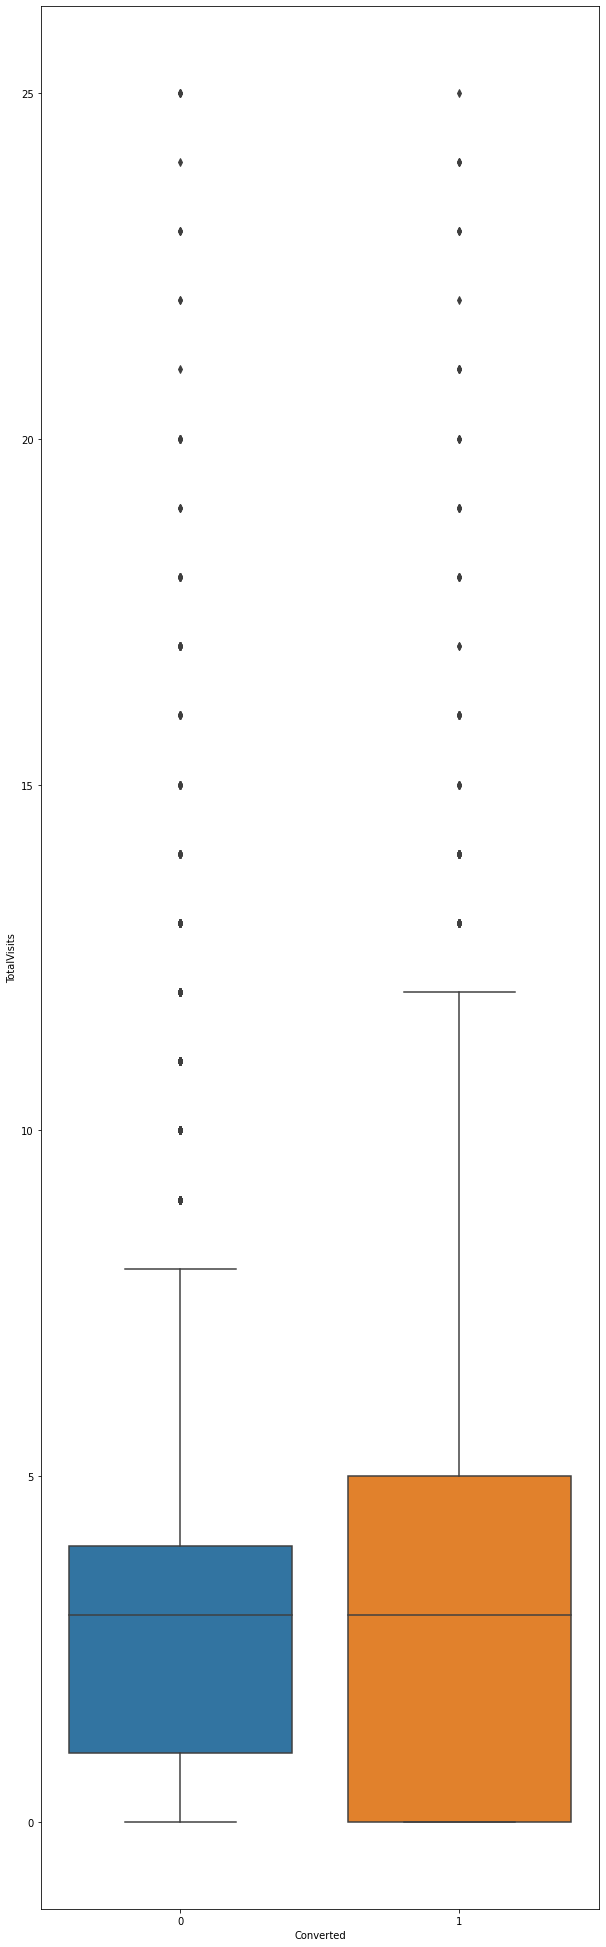

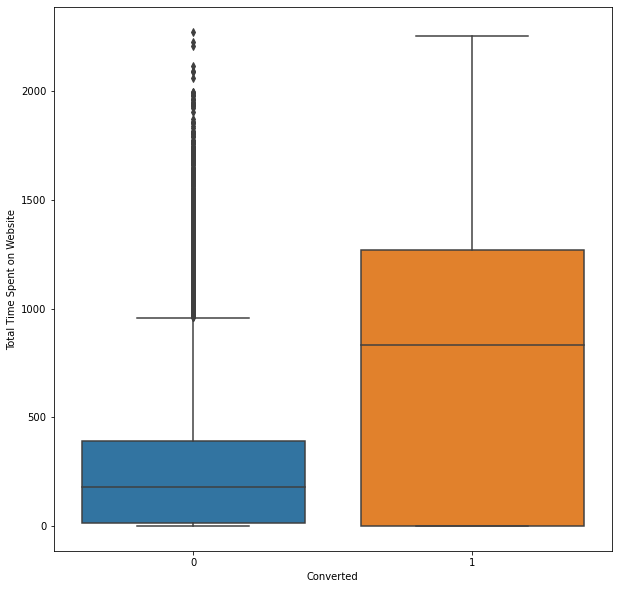

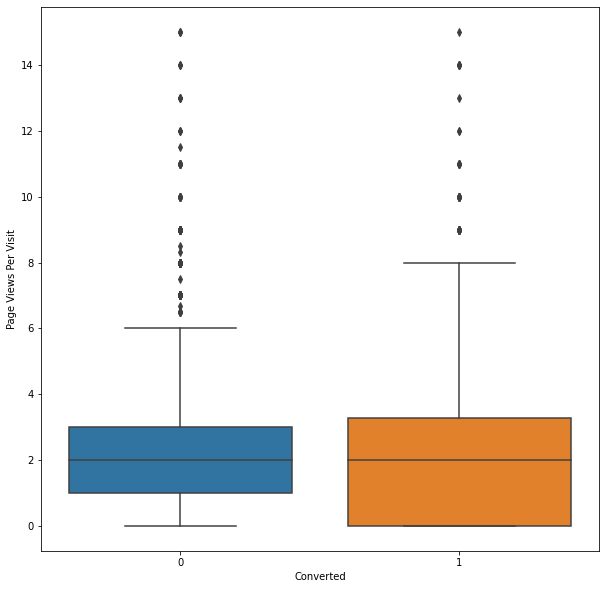

In [395]:
#boxplot after the capping
plt.figure(figsize=(10,35))
sns.boxplot(x=leads_df.Converted, y=leads_df['TotalVisits'])
plt.show()

plt.figure(figsize=(10,10))
sns.boxplot(x=leads_df.Converted, y=leads_df['Total Time Spent on Website'])
plt.show()

plt.figure(figsize=(10,10))
sns.boxplot(x=leads_df.Converted, y=leads_df['Page Views Per Visit'])
plt.show()

- people spending more time on website are more likely to be converted
- median for converted and not converted for both total visits and page views per visit are same. So no inference can be drawn from it

### Step 4: Test-Train Split

In [396]:
leads_df.shape

(9214, 94)

In [397]:
# Putting feature variable to X i.e converted and lead number are not our predictor variable
X = leads_df.drop(['Converted','Lead Number'], axis=1)

X.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_NA,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_NA,Lead Quality_Not Sure,Lead Quality_Worst,Lead Profile_Lateral Student,Lead Profile_NA,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool
0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,2.0,1532,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,0,1.0,305,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,0,2.0,1428,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [398]:
# Putting response variable to y i.e we need to predict this
y = leads_df['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [399]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Step 5: Feature Scaling

In [400]:
#scaling is done to bring all variable to one level and help in speed things up
scaler = StandardScaler()

# using fit_transform as we need to learn and tranform on train set. but in test set we only transform using previous learning

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_NA,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_NA,Lead Quality_Not Sure,Lead Quality_Worst,Lead Profile_Lateral Student,Lead Profile_NA,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool
2178,0,0,0.518566,-0.715514,1.304748,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2924,0,0,0.040004,0.057816,0.010728,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
9108,0,0,0.210762,2.673012,0.814065,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7926,0,0,0.210762,-0.463774,-0.496059,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
7870,0,0,0.826370,-0.461963,1.795431,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [401]:
### Checking the Converted Rate at present
converted = (sum(leads_df['Converted'])/len(leads_df['Converted'].index))*100
converted

38.571738658563056

- almost 39% get converted at present
- not highly balanced but still good enough for analysis

### Step 6: Looking at Correlations

In [402]:
leads_df.columns

Index(['Lead Number', 'Do Not Email', 'Do Not Call', 'Converted',
       'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Origin_Lead Import', 'Lead Origin_Quick Add Form',
       'Lead Source_Direct Traffic', 'Lead Source_Facebook',
       'Lead Source_Google', 'Lead Source_Live Chat', 'Lead Source_NC_EDM',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Pay per Click Ads', 'Lead Source_Press_Release',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_WeLearn',
       'Lead Source_Welingak Website', 'Lead Source_bing', 'Lead Source_blog',
       'Lead Source_testone', 'Lead Source_welearnblog_Home',
       'Lead Source_youtubechannel', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Opened',
       'Last Activity_Form Submitted on Website

In [403]:
leads_df.corr()

,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_NA,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_NA,Lead Quality_Not Sure,Lead Quality_Worst,Lead Profile_Lateral Student,Lead Profile_NA,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool
Lead Number,1.000000,-0.098487,0.011916,0.026010,0.040713,0.020944,0.059786,-0.074958,0.029451,0.104795,0.007749,-0.144494,0.102516,0.134183,0.012139,-0.015242,-0.069033,-0.019858,0.014566,-0.015702,0.025426,0.170822,-0.000608,0.011590,0.014131,0.013047,0.014812,-0.003396,0.006631,0.003786,-0.049021,0.026327,0.108275,0.013795,0.001708,0.053294,0.011150,-0.138762,-0.008255,0.003244,-0.000672,-0.010261,-0.004817,0.003895,-0.011012,-0.032137,-0.010669,-0.001871,-0.015827,0.052586,-0.010182,-0.011171,0.024515,-0.021463,-0.019277,-0.004544,0.033593,-0.017743,0.021339,-0.000867,0.006980,-0.046625,-0.012566,-0.019981,-0.015640,0.067679,-0.013852,-0.006891,-0.011002,0.046124,-0.031836,0.000608,-0.027831,-0.004068,-0.009881,-0.017424,-0.008833,0.039159,0.026242,-0.055174,-0.008372,-0.026207,-0.003015,-0.013643,0.037507,0.024816,0.037792,-0.018437,-0.125941,0.039282,0.106383,-0.028359,-0.074722,-0.089824
Do Not Email,-0.098487,1.000000,-0.004303,-0.134452,-0.003042,-0.046695,0.018068,0.092633,-0.020084,-0.017393,0.035677,0.106657,-0.017393,-0.061739,-0.004303,-0.003042,-0.050230,0.036279,-0.003042,0.050457,-0.037805,-0.012655,-0.004303,-0.003042,-0.000517,-0.007454,-0.003042,-0.003042,-0.003042,0.035677,0.623081,-0.043123,-0.222877,-0.018504,-0.054328,0.147378,0.070401,-0.015400,0.004764,0.012969,0.033862,-0.005846,0.014245,0.011437,-0.020219,0.067085,0.006147,-0.026149,0.000352,-0.036935,-0.013358,0.01690

In [404]:
# Create correlation matrix
leads_df_corr = leads_df.corr().abs()

# Select upper triangle of correlation matrix
upper = leads_df_corr.where(np.triu(np.ones(leads_df_corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

# Drop features 
leads_df=leads_df.drop(leads_df[to_drop], axis=1)
leads_df.shape

(9214, 85)

In [405]:
leads_df.head()

,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Unemployed,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_NA,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,Lead Profile_Lateral Student,Lead Profile_NA,Lead Profile_Other Leads,Lead Profile_Student of SomeSchool
0,660737,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,660728,0,0,0,5.0,674,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,660727,0,0,1,2.0,1532,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,660719,0,0,0,1.0,305,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,660681,0,0,1,2.0,1428,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


### Step 7: Model Building
splitting our data into a training set and a test set.

#### Running Your First Training Model

In [406]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6449 entries, 2178 to 5655
Data columns (total 92 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Do Not Email                                            6449 non-null   int64  
 1   Do Not Call                                             6449 non-null   int64  
 2   TotalVisits                                             6449 non-null   float64
 3   Total Time Spent on Website                             6449 non-null   float64
 4   Page Views Per Visit                                    6449 non-null   float64
 5   Lead Origin_Landing Page Submission                     6449 non-null   uint8  
 6   Lead Origin_Lead Add Form                               6449 non-null   uint8  
 7   Lead Origin_Lead Import                                 6449 non-null   uint8  
 8   Lead Origin_Quick Add Form         

In [407]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6449
Model:                            GLM   Df Residuals:                     6360
Model Family:                Binomial   Df Model:                           88
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 11 Feb 2021   Deviance:                          nan
Time:                        20:31:18   Pearson chi2:                 4.52e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                  -5.298e+13   4.68e+07  -1.13e+06      0.000    -5.3e+13    -5.3e+13
Do Not Email                                           -3.074e+14   4.22e+06  -7.28e+07      0.000   -3.07e+14   -3.07e+14
Do Not Call                                             3.494e+15   4.78e+07   7.31e+07      0.000    3.49e+15    3.49e+15
TotalVisits                                             9.273e+13   1.25e+06   7.43e+07      0.000    9.27e+13    9.27e+13
Total Time Spent on Website                             4.365e+14   1.01e+06   4.31e+08      0.000    4.36e+14    4.36e+14
Page Views Per Visit                                   -5.764e+13   1.35e+06  -4.26e+07      0.000   -5.76e+13   -5.76e+13
Lead Origin_Landing Page Submission                    -2.838e+14   3.44e+06  -8.25e+07      0.000   -2.84e+14   -2.84e+14
Lead Origin_Lead Add Form                               7.132e+14   1.38e+07   5.17e+07      0.000    7.13e+14    7.13e+14
Lead Origin_Lead Import                                 2.357e+15   6.88e+07   3.42e+07      0.000    2.36e+15    2.36e+15
Lead Origin_Quick Add Form                                -3.8652   2.53e-07  -1.53e+07      0.000      -3.865      -3.865
Lead Source_Direct Traffic                              1.692e+15   4.26e+07   3.97e+07      0.000    1.69e+15    1.69e+15
Lead Source_Facebook                                   -1.396e+15   8.01e+07  -1.74e+07      0.000    -1.4e+15    -1.4e+15
Lead Source_Google                                      1.768e+15   4.25e+07   4.16e+07      0.000    1.77e+15    1.77e+15
Lead Source_Live Chat                                   4.494e+15   7.84e+07   5.74e+07      0.000    4.49e+15    4.49e+15
Lead Source_NC_EDM                                      6.264e+15   7.94e+07   7.89e+07      0.000    6.26e+15    6.26e+15
Lead Source_Olark Chat                                  2.368e+15   4.27e+07   5.54e+07      0.000    2.37e+15    2.37e+15
Lead Source_Organic Search                              1.834e+15   4.26e+07    4.3e+07      0.000    1.83e+15    1.83e+15
Lead Source_Pay per Click Ads                          -5.621e+14   7.96e+07  -7.06e+06      0.000   -5.62e+14   -5.62e+14
Lead Source_Press_Release                                -17.0350   3.76e-07  -4.53e+07      0.000     -17.035     -17.035
Lead Source_Reference                                   8.539e+14   4.04e+07   2.11e+07      0.000    8.54e+14    8.54e+14
Lead Source_Referral Sites                               1.55e+15   4.32e+07   3.59e+07      0.000    1.55e+15    1.55e+15
Lead Source_Social Media                                2.359e+15   6.39e+07   3.69e+07      0.000    2.36e+15    2.36e+15
Lead Sou

- as we can see there are lot of features which are not sgnificant we would need to remove them by RFE and improve our analysis


### Step 8: Feature Selection Using RFE

In [408]:
logreg = LogisticRegression()
rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False,  True, False,  True, False,
       False, False])

In [409]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', False, 24),
 ('Do Not Call', False, 57),
 ('TotalVisits', False, 42),
 ('Total Time Spent on Website', False, 3),
 ('Page Views Per Visit', False, 48),
 ('Lead Origin_Landing Page Submission', False, 17),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 28),
 ('Lead Origin_Quick Add Form', False, 78),
 ('Lead Source_Direct Traffic', False, 50),
 ('Lead Source_Facebook', False, 16),
 ('Lead Source_Google', False, 51),
 ('Lead Source_Live Chat', False, 71),
 ('Lead Source_NC_EDM', False, 18),
 ('Lead Source_Olark Chat', False, 2),
 ('Lead Source_Organic Search', False, 55),
 ('Lead Source_Pay per Click Ads', False, 74),
 ('Lead Source_Press_Release', False, 75),
 ('Lead Source_Reference', False, 8),
 ('Lead Source_Referral Sites', False, 40),
 ('Lead Source_Social Media', False, 59),
 ('Lead Source_WeLearn', False, 70),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 44),
 ('Lead Source_blog', False, 77),
 ('Lead Sour

In [410]:
col = X_train.columns[rfe.support_]

In [411]:
X_train.columns[~rfe.support_]

Index(['Do Not Email', 'Do Not Call', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Origin_Quick Add Form', 'Lead Source_Direct Traffic',
       'Lead Source_Facebook', 'Lead Source_Google', 'Lead Source_Live Chat',
       'Lead Source_NC_EDM', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Pay per Click Ads',
       'Lead Source_Press_Release', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_bing', 'Lead Source_blog',
       'Lead Source_testone', 'Lead Source_welearnblog_Home',
       'Lead Source_youtubechannel', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Olark Chat Conversation', 'Last Activity_Others',
       'Last Activity_Page Visited on Website',
   

##### Assessing the model with StatsModels

In [413]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6449
Model:                            GLM   Df Residuals:                     6433
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1490.5
Date:                Thu, 11 Feb 2021   Deviance:                       2980.9
Time:                        20:32:51   Pearson chi2:                 8.30e+03
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.4352      0.240    -14.291      0.000      -3.906      -2.964
Lead Origin_Lead Add Form                   -0.1071      0.332     -0.323      0.747      -0.758       0.544
Lead Source_Welingak Website                 5.2587      1.071      4.909      0.000       3.159       7.358
Last Activity_Email Opened                   1.2233      0.134      9.148      0.000       0.961       1.485
Last Activity_SMS Sent                       2.8746      0.136     21.064      0.000       2.607       3.142
Specialization_Travel and Tourism           -1.4149      0.386     -3.661      0.000      -2.172      -0.658
Tags_Busy                                    2.8021      0.285      9.820      0.000       2.243       3.361
Tags_Closed by Horizzon                      8.9519      1.035      8.650      0.000       6.923      10.980
Tags_Lost to EINS                            7.7573      0.630     12.311      0.000       6.522       8.992
Tags_NA                                      2.0751      0.217      9.556      0.000       1.650       2.501
Tags_Not doing further education           -21.5891   1.85e+04     -0.001      0.999   -3.63e+04    3.63e+04
Tags_Ringing                                -1.0680      0.284     -3.754      0.000      -1.626      -0.510
Tags_Will revert after reading the email     6.0758      0.252     24.144      0.000       5.583       6.569
Tags_switched off                           -1.8425      0.623     -2.956      0.003      -3.064      -0.621
Lead Quality_Worst                          -2.2003      0.601     -3.662      0.000      -3.378      -1.023
Lead Profile_NA                             -1.2610      0.185     -6.826      0.000      -1.623      -0.899
============================================================================================================
"""

In [414]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,Lead Source_Welingak Website,1.29
12,Tags_switched off,1.14
5,Tags_Busy,1.11
9,Tags_Not doing further education,1.10
7,Tags_Lost to EINS,1.09
4,Specialization_Travel and Tourism,1.02
13,Lead Quality_Worst,0.47
11,Tags_Will revert after reading the email,0.25
3,Last Activity_SMS Sent,0.17
2,Last Activity_Email Opened,0.13


In [415]:
col1=col.drop(['Tags_Not doing further education'])

In [416]:
X_train_sm = sm.add_constant(X_train[col1])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6449
Model:                            GLM   Df Residuals:                     6434
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1492.8
Date:                Thu, 11 Feb 2021   Deviance:                       2985.5
Time:                        20:35:10   Pearson chi2:                 8.36e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.5109      0.239    -14.671      0.000      -3.980      -3.042
Lead Origin_Lead Add Form                   -0.1091      0.331     -0.329      0.742      -0.758       0.540
Lead Source_Welingak Website                 5.2610      1.071      4.912      0.000       3.162       7.360
Last Activity_Email Opened                   1.2245      0.134      9.159      0.000       0.962       1.486
Last Activity_SMS Sent                       2.8763      0.136     21.080      0.000       2.609       3.144
Specialization_Travel and Tourism           -1.4115      0.387     -3.648      0.000      -2.170      -0.653
Tags_Busy                                    2.8735      0.285     10.083      0.000       2.315       3.432
Tags_Closed by Horizzon                      9.0255      1.035      8.722      0.000       6.997      11.054
Tags_Lost to EINS                            7.8320      0.630     12.431      0.000       6.597       9.067
Tags_NA                                      2.1459      0.217      9.897      0.000       1.721       2.571
Tags_Ringing                                -0.9964      0.284     -3.508      0.000      -1.553      -0.440
Tags_Will revert after reading the email     6.1485      0.251     24.485      0.000       5.656       6.641
Tags_switched off                           -1.7706      0.623     -2.842      0.004      -2.992      -0.549
Lead Quality_Worst                          -2.2125      0.599     -3.693      0.000      -3.387      -1.038
Lead Profile_NA                             -1.2572      0.184     -6.815      0.000      -1.619      -0.896
============================================================================================================
"""

In [417]:
col2=col1.drop(['Lead Origin_Lead Add Form'])

In [418]:
X_train_sm = sm.add_constant(X_train[col2])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6449
Model:                            GLM   Df Residuals:                     6435
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1492.8
Date:                Thu, 11 Feb 2021   Deviance:                       2985.6
Time:                        20:36:14   Pearson chi2:                 8.51e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.5170      0.239    -14.734      0.000      -3.985      -3.049
Lead Source_Welingak Website                 5.1527      1.019      5.055      0.000       3.155       7.150
Last Activity_Email Opened                   1.2232      0.134      9.155      0.000       0.961       1.485
Last Activity_SMS Sent                       2.8738      0.136     21.100      0.000       2.607       3.141
Specialization_Travel and Tourism           -1.4047      0.386     -3.643      0.000      -2.161      -0.649
Tags_Busy                                    2.8746      0.285     10.088      0.000       2.316       3.433
Tags_Closed by Horizzon                      8.9785      1.024      8.766      0.000       6.971      10.986
Tags_Lost to EINS                            7.8288      0.630     12.427      0.000       6.594       9.064
Tags_NA                                      2.1455      0.217      9.894      0.000       1.720       2.570
Tags_Ringing                                -0.9958      0.284     -3.506      0.000      -1.553      -0.439
Tags_Will revert after reading the email     6.1380      0.249     24.662      0.000       5.650       6.626
Tags_switched off                           -1.7663      0.623     -2.836      0.005      -2.987      -0.545
Lead Quality_Worst                          -2.2063      0.599     -3.685      0.000      -3.380      -1.033
Lead Profile_NA                             -1.2501      0.183     -6.822      0.000      -1.609      -0.891
============================================================================================================
"""

In [419]:
vif = pd.DataFrame()
vif['Features'] = X_train[col2].columns
vif['VIF'] = [variance_inflation_factor(X_train[col2].values, i) for i in range(X_train[col2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,Tags_switched off,1.14
4,Tags_Busy,1.11
6,Tags_Lost to EINS,1.08
0,Lead Source_Welingak Website,1.04
3,Specialization_Travel and Tourism,1.02
11,Lead Quality_Worst,0.44
9,Tags_Will revert after reading the email,0.24
2,Last Activity_SMS Sent,0.17
1,Last Activity_Email Opened,0.13
8,Tags_Ringing,0.13


- P value for all the features are now 0 so all are now significant

- VIF values are low so there is nothing to drop

In [420]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

2178    0.562703
2924    0.995656
9108    0.162602
7926    0.067758
7870    0.198069
7615    0.010564
2718    0.010564
500     0.052693
8328    0.067758
505     0.930486
dtype: float64

In [421]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.56270252, 0.99565598, 0.16260245, 0.06775837, 0.19806865,
       0.01056401, 0.01056401, 0.05269327, 0.06775837, 0.93048558])

##### Creating a dataframe with the actual converted flag and the predicted probabilities

In [422]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['Lead Number'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number
0,0,0.562703,2178
1,1,0.995656,2924
2,0,0.162602,9108
3,0,0.067758,7926
4,0,0.198069,7870


In [423]:
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,Predicted
0,0,0.562703,2178,1
1,1,0.995656,2924,1
2,0,0.162602,9108,0
3,0,0.067758,7926,0
4,0,0.198069,7870,0


In [424]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[3620  299]
 [ 297 2233]]


In [425]:
# Predicted       not_converted    converted
# Actual
# not_converted        3620          299
# converted            297           2233 

In [426]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.9075825709412312


- 91 is a pretty good accuracy

In [427]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [428]:
# Let's see the sensitivity of our logistic regression model- customers who actually converted and same was predicted
TP / float(TP+FN)

0.8826086956521739

In [429]:
# Calculate false postive rate - predicting converted when customer does not have converted
print(FP/ float(TN+FP))

0.07629497320745088


In [430]:
# positive predictive value 
print (TP / float(TP+FP))

0.881911532385466


In [431]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9241766658156753


### Step 9: Plotting the ROC Curve

In [432]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [433]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

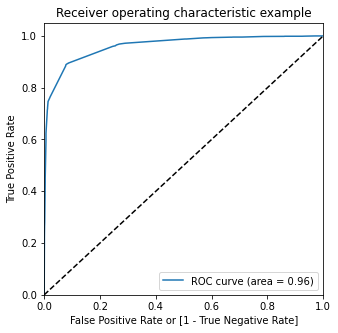

In [434]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

- This looks like a good curve with value of around 0.96

### Step 10: Finding Optimal Cutoff Point

In [435]:
# Creating columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.562703,2178,1,1,1,1,1,1,1,0,0,0,0
1,1,0.995656,2924,1,1,1,1,1,1,1,1,1,1,1
2,0,0.162602,9108,0,1,1,0,0,0,0,0,0,0,0
3,0,0.067758,7926,0,1,0,0,0,0,0,0,0,0,0
4,0,0.198069,7870,0,1,1,0,0,0,0,0,0,0,0


In [436]:
# Calculating accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.392309  1.000000  0.000000
0.1   0.1  0.823849  0.968775  0.730288
0.2   0.2  0.906497  0.894862  0.914009
0.3   0.3  0.907428  0.892885  0.916816
0.4   0.4  0.907738  0.884190  0.922940
0.5   0.5  0.907583  0.882609  0.923705
0.6   0.6  0.894557  0.763241  0.979331
0.7   0.7  0.894092  0.760870  0.980097
0.8   0.8  0.883858  0.722530  0.988007
0.9   0.9  0.882773  0.719763  0.988007


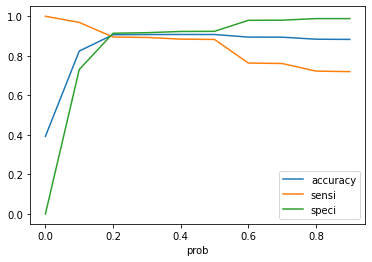

In [437]:
# Plotting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.2 is the optimum point to take it as a cutoff probability.

In [439]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.562703,2178,1,1,1,1,1,1,1,0,0,0,0,1
1,1,0.995656,2924,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.162602,9108,0,1,1,0,0,0,0,0,0,0,0,0
3,0,0.067758,7926,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.198069,7870,0,1,1,0,0,0,0,0,0,0,0,0


In [440]:
# checking the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.906497131338192

In [441]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3582,  337],
       [ 266, 2264]])

In [442]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [443]:
# sensitivity of logistic regression model
TP / float(TP+FN)

0.8948616600790514

In [444]:
# specificity
TN / float(TN+FP)

0.914008675682572

In [445]:
# Calculating false postive rate - predicting converted when customer do not convert
print(FP/ float(TN+FP))

0.08599132431742791


In [446]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8704344482891195


In [447]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9308731808731808


### Step 11: Making predictions on the test set

In [448]:
# scaling test data
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

In [449]:
X_test = X_test[col2]
X_test.head()

,Lead Source_Welingak Website,Last Activity_Email Opened,Last Activity_SMS Sent,Specialization_Travel and Tourism,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_NA,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,Lead Quality_Worst,Lead Profile_NA
2729,0,0,1,0,0,0,0,0,0,1,0,0,1
5463,0,1,0,0,0,0,0,1,0,0,0,0,1
6476,0,1,0,0,0,0,0,0,1,0,0,0,1
4135,0,1,0,0,0,0,0,0,0,1,0,0,0
5408,0,0,1,0,0,0,0,0,0,1,0,0,1


In [450]:
X_test_sm = sm.add_constant(X_test)

In [451]:
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

2729    0.985863
5463    0.198069
6476    0.010564
4135    0.979047
5408    0.985863
2681    0.995909
2271    0.562703
2659    0.979047
3186    0.562703
8213    0.995771
dtype: float64

In [452]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
2729,0.985863
5463,0.198069
6476,0.010564
4135,0.979047
5408,0.985863


In [453]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [454]:
# Putting CustID to index
y_test_df['Lead Number'] = y_test_df.index

In [455]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,Converted,Lead Number,0
0,1,2729,0.985863
1,0,5463,0.198069
2,0,6476,0.010564
3,1,4135,0.979047
4,1,5408,0.985863


In [456]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['Lead Number','Converted','Converted_Prob'], axis=1)
y_pred_final.head()

,Lead Number,Converted,Converted_Prob
0,2729,1,0.985863
1,5463,0,0.198069
2,6476,0,0.010564
3,4135,1,0.979047
4,5408,1,0.985863


In [457]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,Lead Number,Converted,Converted_Prob,final_predicted
0,2729,1,0.985863,1
1,5463,0,0.198069,0
2,6476,0,0.010564,0
3,4135,1,0.979047,1
4,5408,1,0.985863,1


In [458]:
y_pred_final['Lead_Score'] = y_pred_final.Converted_Prob.map( lambda x: round(x*100))
y_pred_final.head()

,Lead Number,Converted,Converted_Prob,final_predicted,Lead_Score
0,2729,1,0.985863,1,99
1,5463,0,0.198069,0,20
2,6476,0,0.010564,0,1
3,4135,1,0.979047,1,98
4,5408,1,0.985863,1,99


In [459]:
# overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.9009041591320073

In [460]:
confusion_test = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion_test

array([[1585,  156],
       [ 118,  906]])

In [461]:
TP = confusion_test[1,1] # true positive 
TN = confusion_test[0,0] # true negatives
FP = confusion_test[0,1] # false positives
FN = confusion_test[1,0] # false negatives

In [462]:
# sensitivity
TP / float(TP+FN)

0.884765625

In [463]:
# specificity
TN / float(TN+FP)

0.9103963239517519

- Training data:
    - accuracy : 0.90
    - sensitivity: 0.89
    - specificity: 0.91   
- Test data:
    - accuracy : 0.90
    - sensitivity: 0.88
    - specificity: 0.91
- Both training and test results match so we can say our model is good enough
 